#**End-to-End Supply Chain Analytics Project.**

Project Overview: End-to-End Supply Chain Optimization
Project Goal This project simulates a real-world supply chain analytics workflow to identify operational inefficiencies and revenue risks in a global logistics network. By integrating disparate datasets—Sales Orders, Warehouse Inventory, and Fulfillment Logs—we aim to build a data-driven strategy that optimizes inventory levels, reduces shipping costs, and improves delivery performance.

Key Objectives

Demand Planning: Analyze sales trends across global markets (LATAM, Europe, Asia) to guide inventory positioning.

Logistics Optimization: Audit carrier performance to expose "Service Level Mismatches" (e.g., high-cost shipping with low reliability).

Inventory Health: Detect critical data synchronization errors ("Ghost Orders") and financial waste ("Dead Stock") to free up working capital.

Warehouse Efficiency: Measure pick-and-pack cycle times to identify product-level bottlenecks slowing down fulfillment.

The Tech Stack

Language: Python

Libraries: Pandas (ETL & Data Cleaning), Seaborn/Matplotlib (Visualization)

Techniques: Data Merging (Joins), Time-Series Analysis, Anomaly Detection.

Business Impact The final analysis delivers actionable insights to cut logistics costs by switching underperforming carriers, recovering capital from unsold inventory, and fixing IT gaps that cause stockouts.



---
#**Phase 1:Environment Setup & Data Ingestion**      
Orders & Shipments: Transactional data containing sales, customer details, and shipping modes.

Inventory: Warehouse stock levels and unit costs.

Fulfillment: Operational logs tracking the time taken to pick, pack, and ship orders.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

# Suppress annoying warning messages for a cleaner view
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!




---
#**Phase 2: Data Cleaning & Strategy**

Sanitization: Stripping hidden whitespace from column headers to prevent indexing errors.

Type Conversion: Transforming text-based dates (e.g., '2015-01') into datetime objects for accurate Lead Time calculation.

Error Handling: identifying and neutralizing non-numeric characters (like ' - ') in financial columns to ensure accurate profit analysis.


In [3]:

fulfil = pd.read_csv('fulfillment.csv')

inv = pd.read_csv('inventory.csv')

ord_ship = pd.read_csv('orders_and_shipments.csv')

print("Data loading complete. Here is a preview of Orders & Shipments:")
display(ord_ship.head())

Data loading complete. Here is a preview of Orders & Shipments:


,Order ID,Order Item ID,Order YearMonth,Order Year,Order Month,Order Day,Order Time,Order Quantity,Product Department,Product Category,...,Customer Country,Warehouse Country,Shipment Year,Shipment Month,Shipment Day,Shipment Mode,Shipment Days - Scheduled,Gross Sales,Discount %,Profit
0,3535,8793,201502,2015,2,21,14:07,1,Fan Shop,Fishing,...,Mexico,Puerto Rico,2015,2,27,Standard Class,4,400,0.25,200
1,4133,10320,201503,2015,3,2,07:37,1,Fan Shop,Fishing,...,Brazil,Puerto Rico,2015,3,6,Standard Class,4,400,0.09,200
2,7396,18517,201504,2015,4,18,22:47,1,Fan Shop,Fishing,...,Mexico,Puerto Rico,2015,4,20,Standard Class,4,400,0.06,200
3,11026,27608,201506,2015,6,10,22:32,1,Fan Shop,Fishing,...,Denmark,Puerto Rico,2015,6,12,Standard Class,4,400,0.15,200
4,11026,27609,201506,2015,6,10,22:32,1,Fan Shop,Fishing,...,Denmark,Puerto Rico,2015,6,12,Standard Class,4,400,0.13,200


In Supply Chain Management, we live by the rule: "Garbage In, Garbage Out." If your data says a package weighs "Heavy" (text) instead of "50kg" (number), you cannot calculate shipping costs. If your delivery date is missing, you cannot measure delay.

We are going to perform a Data Audit. We need to check two things:

Data Types: Are numbers actually stored as numbers? Are dates stored as dates?

Missing Values: Do we have gaps in our data (e.g., missing customer countries)?

In [4]:
# 1. Audit Orders & Shipments
print("------- ORDERS & SHIPMENTS AUDIT -------")
# .info() shows us the data type of every column (int, float, object/text)
ord_ship.info()
print("\n--- Missing Values ---")
# .isnull().sum() counts how many empty cells exist in each column
print(ord_ship.isnull().sum())

print("\n\n------- INVENTORY AUDIT -------")
inv.info()

print("\n\n------- FULFILLMENT AUDIT -------")
fulfil.info()

------- ORDERS & SHIPMENTS AUDIT -------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30871 entries, 0 to 30870
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Order ID                     30871 non-null  int64 
 1    Order Item ID               30871 non-null  int64 
 2    Order YearMonth             30871 non-null  int64 
 3    Order Year                  30871 non-null  int64 
 4    Order Month                 30871 non-null  int64 
 5    Order Day                   30871 non-null  int64 
 6   Order Time                   30871 non-null  object
 7   Order Quantity               30871 non-null  int64 
 8   Product Department           30871 non-null  object
 9   Product Category             30871 non-null  object
 10  Product Name                 30871 non-null  object
 11   Customer ID                 30871 non-null  int64 
 12  Customer Market              30871 non-null  ob

In [25]:
from IPython.display import display
# 1. Clean Column Names (Remove hidden spaces at start/end)
# Example: ' Order ID ' becomes 'Order ID'
ord_ship.columns = ord_ship.columns.str.strip()
print("Column names cleaned!")

# 2. Create a 'Master Date' Column
# We combine the existing Year, Month, Day columns into a standard datetime format
ord_ship['order_date'] = pd.to_datetime(ord_ship[['Order Year', 'Order Month', 'Order Day']].astype(str).agg('-'.join, axis=1))

# 3. Clean 'Discount %'
# We found '  -  ' in the data. We replace it with 0 and convert column to float.
ord_ship['Discount %'] = ord_ship['Discount %'].replace('  -  ', 0).astype(float)

# Let's verify the changes
print("\n--- Data Check After Cleaning ---")
print(ord_ship[['order_date', 'Discount %']].info())
display(ord_ship[['order_date', 'Discount %']].head())

Column names cleaned!

--- Data Check After Cleaning ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30871 entries, 0 to 30870
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   order_date  30871 non-null  datetime64[ns]
 1   Discount %  30871 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 482.5 KB
None


,order_date,Discount %
0,2015-02-21,0.25
1,2015-03-02,0.09
2,2015-04-18,0.06
3,2015-06-10,0.15
4,2015-06-10,0.13


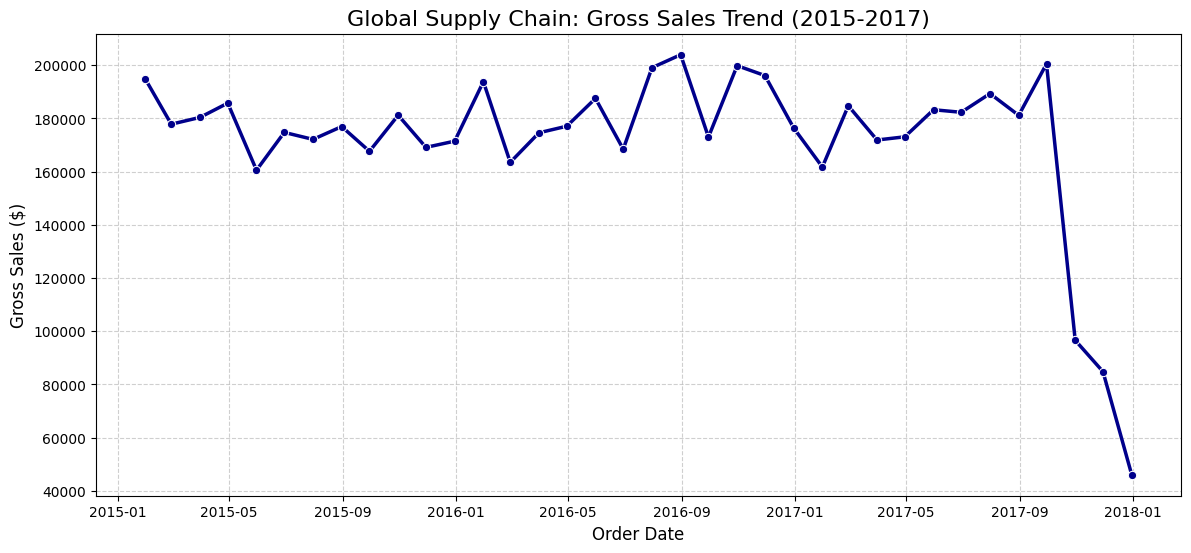

In [9]:
# Create a monthly sales trend
# We use resample('M') which works like a "Pivot Table" grouping by Month
monthly_sales = ord_ship.set_index('order_date').resample('M')['Gross Sales'].sum().reset_index()

# Visualize the Trend
plt.figure(figsize=(14, 6)) # Make the chart wide
sns.lineplot(data=monthly_sales, x='order_date', y='Gross Sales', marker='o', linewidth=2.5, color='darkblue')

# Formatting for professional look
plt.title('Global Supply Chain: Gross Sales Trend (2015-2017)', fontsize=16)
plt.ylabel('Gross Sales ($)', fontsize=12)
plt.xlabel('Order Date', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6) # Add gridlines for readability
plt.show()



---
#**Phase 3: Network Strategy**                
Demand Segmentation: We visualize sales trends over time and break down revenue by Market (Geography) and Product Category to identify our 'Cash Cows.'

Logistics Audit: We evaluate our shipping carriers by calculating On-Time Delivery (OTD) rates. By comparing 'Scheduled Days' vs. 'Actual Days,' we expose Service Level Mismatches—specifically identifying premium shipping modes that fail to deliver on speed promises."

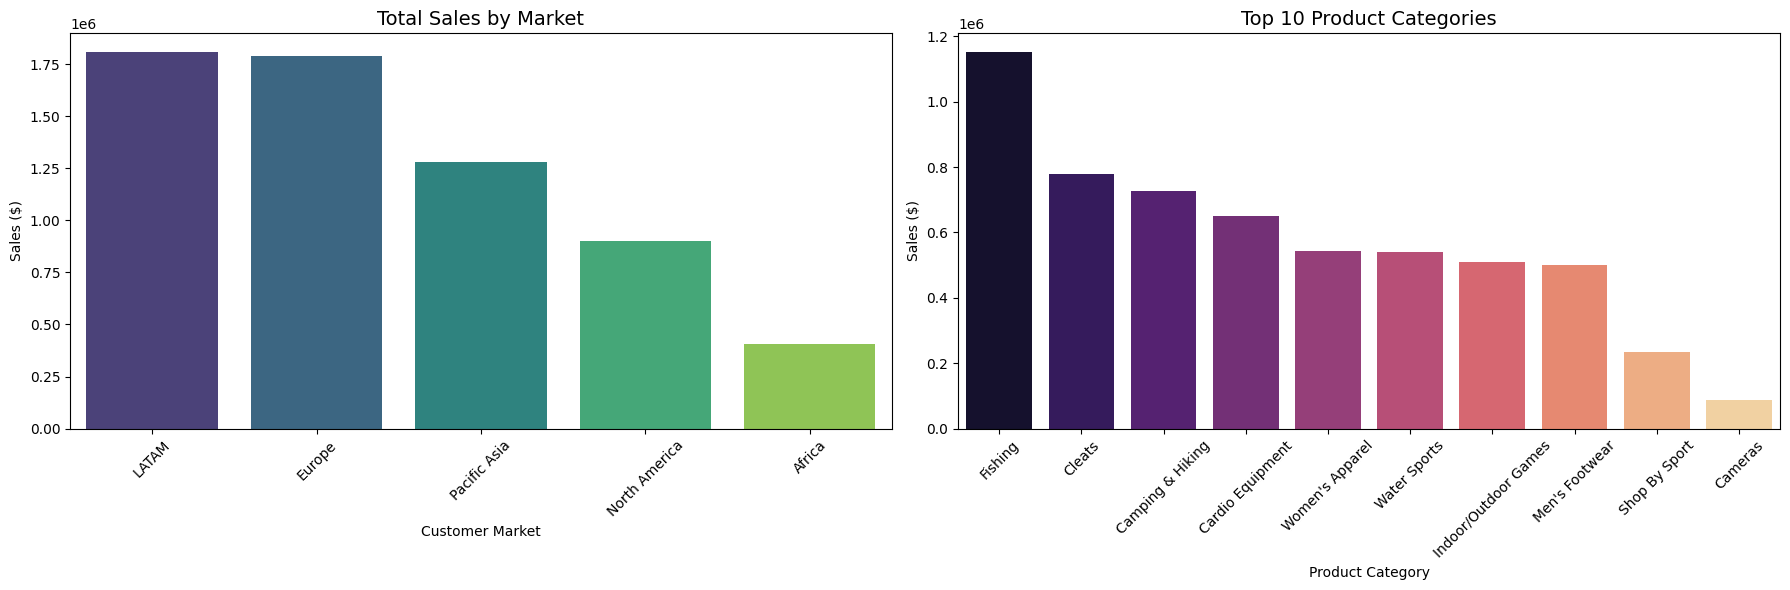

In [10]:
# Create a 2-panel visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Chart 1: Sales by Market (Where is the money coming from?)
market_sales = ord_ship.groupby('Customer Market')['Gross Sales'].sum().sort_values(ascending=False)
sns.barplot(x=market_sales.index, y=market_sales.values, ax=axes[0], palette='viridis')
axes[0].set_title('Total Sales by Market', fontsize=14)
axes[0].set_ylabel('Sales ($)')
axes[0].tick_params(axis='x', rotation=45)

# Chart 2: Sales by Product Category (What are we actually moving?)
# We take the top 10 categories to keep the chart readable
cat_sales = ord_ship.groupby('Product Category')['Gross Sales'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=cat_sales.index, y=cat_sales.values, ax=axes[1], palette='magma')
axes[1].set_title('Top 10 Product Categories', fontsize=14)
axes[1].set_ylabel('Sales ($)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#**3B** -**Logistics & Delivery Performance**                       

---

Are we delivering on time? In
Supply Chain, the "Holy Grail" metric is OTD (On-Time Delivery).

On-Time: Customer happy.

Late: Customer churns, penalties incur.

We have a column Shipment Days - Scheduled (The Promise) and we can calculate the Actual Days Taken (The Reality).

Step 1: Calculate Delivery Performance We will create a new metric called delivery_status. If Actual Days > Scheduled Days, the shipment is Late.                   

---

Conclusion:

First Class: 89.7% Late (Fail)

Same Day: 21.9% Late (Best Performer)

Expert Analysis: "Paying More to Wait More" In Supply Chain, we call this a Service Level Mismatch.

The Problem: company is likely paying a premium to logistics carriers (like FedEx/UPS) for "First Class" service, but the carriers are failing 9 out of 10 times.

The Action: should immediately renegotiate contracts or switch carriers. You are bleeding money on shipping costs without getting the speed.

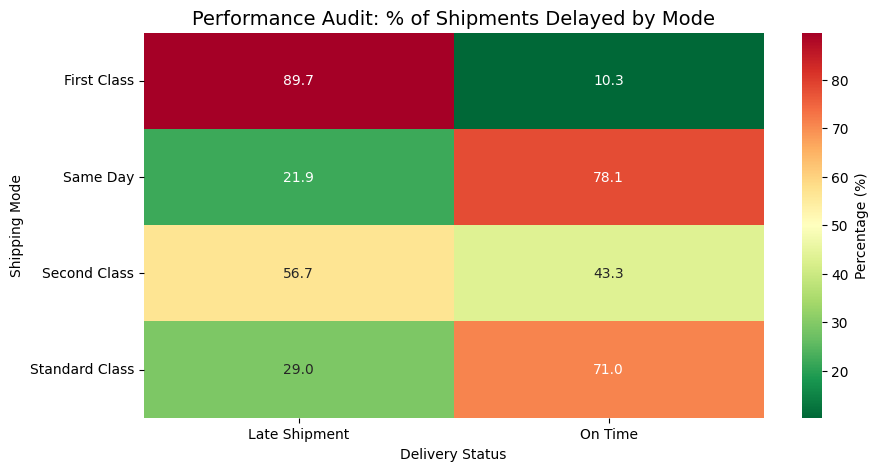

Total Late Shipments detected: 13442


In [12]:
# 1. Create a Master Shipment Date
ord_ship['shipment_date'] = pd.to_datetime(ord_ship[['Shipment Year', 'Shipment Month', 'Shipment Day']].astype(str).agg('-'.join, axis=1))

# 2. Calculate Actual Shipping Days (Ship Date - Order Date)
ord_ship['actual_days'] = (ord_ship['shipment_date'] - ord_ship['order_date']).dt.days

# 3. Determine Status: Late vs On Time
# If actual days > scheduled days, it is "Late Shipment"
ord_ship['delivery_status'] = np.where(ord_ship['actual_days'] > ord_ship['Shipment Days - Scheduled'], 'Late Shipment', 'On Time')

# 4. Visualize the Failure Rate by Shipping Mode
plt.figure(figsize=(10, 5))

# Calculate percentage of late shipments per mode
late_data = ord_ship.groupby('Shipment Mode')['delivery_status'].value_counts(normalize=True).unstack() * 100

# Plot heatmap (Red = High Late %, Green = Low Late %)
sns.heatmap(late_data, annot=True, fmt=".1f", cmap='RdYlGn_r', cbar_kws={'label': 'Percentage (%)'})
plt.title('Performance Audit: % of Shipments Delayed by Mode', fontsize=14)
plt.ylabel('Shipping Mode')
plt.xlabel('Delivery Status')
plt.show()

# Quick Stat
late_count = ord_ship[ord_ship['delivery_status'] == 'Late Shipment'].shape[0]
print(f"Total Late Shipments detected: {late_count}")



---
#**Phase 4: Inventory Optimization & Risk Detection**
Inventory is the largest capital expense in supply chain. In this phase, we integrate Sales Data (Demand) with Warehouse Data (Supply) to detect inefficiencies.

Key Metrics Calculated:

Ghost Orders (Data Latency): Identifying instances where sales occurred despite the system reporting zero inventory, indicating critical synchronization failures.

Dead Stock (Financial Waste): calculating the total value of capital tied up in products that have zero sales.

In [26]:
import pandas as pd
import numpy as np

# --- STEP 1: RELOAD EVERYTHING (Fresh Start) ---
print("1. Loading Data...")
ord_ship = pd.read_csv('orders_and_shipments.csv')
inv = pd.read_csv('inventory.csv')

# --- STEP 2: AGGRESSIVE CLEANING ---
# We strip whitespace from ALL column names in BOTH files
ord_ship.columns = [col.strip() for col in ord_ship.columns]
inv.columns = [col.strip() for col in inv.columns]

print("   Columns Cleaned.")
print(f"   Inventory Keys: {inv.columns.tolist()}")
print(f"   Orders Keys: {ord_ship.columns.tolist()}")

# --- STEP 3: STANDARDIZE COLUMN NAMES ---
# We need the "Join Keys" to be identical strings
# Inventory has 'Year Month', Orders has 'Order YearMonth'
inv.rename(columns={
    'Year Month': 'YearMonth',
    'Warehouse Inventory': 'Stock Level',
    'Inventory Cost Per Unit': 'Unit Cost'
}, inplace=True)

# Orders has 'Order YearMonth' -> We'll rename it in the aggregate step below
# ensure Product Name matches
# (No action needed if both are 'Product Name', which the print confirms)

# --- STEP 4: AGGREGATE DEMAND ---
# Group Orders by Product and Month
print("2. Aggregating Sales...")
sales_agg = ord_ship.groupby(['Product Name', 'Order YearMonth'])['Order Quantity'].sum().reset_index()

# Rename to match Inventory's new 'YearMonth' column
sales_agg.rename(columns={
    'Order Quantity': 'Total Sold',
    'Order YearMonth': 'YearMonth'
}, inplace=True)

# --- STEP 5: MERGE ---
print("3. Merging Supply & Demand...")
supply_demand = pd.merge(sales_agg, inv, on=['Product Name', 'YearMonth'], how='inner')

# --- STEP 6: CALCULATE RISKS ---
# Stockout Flag: Sold items but Stock was 0
supply_demand['Stockout_Flag'] = (supply_demand['Stock Level'] == 0) & (supply_demand['Total Sold'] > 0)

# Turnover Ratio
supply_demand['Turnover Ratio'] = supply_demand['Total Sold'] / supply_demand['Stock Level']
supply_demand['Turnover Ratio'] = supply_demand['Turnover Ratio'].replace([np.inf, -np.inf], np.nan)

print("SUCCESS! Merge Complete.")
display(supply_demand.head())

# --- STEP 7: THE GHOST ORDER CHECK ---
ghost_count = supply_demand[supply_demand['Stockout_Flag'] == True].shape[0]
print(f"\n[ALERT] Ghost Orders Detected: {ghost_count}")

1. Loading Data...
   Columns Cleaned.
   Inventory Keys: ['Product Name', 'Year Month', 'Warehouse Inventory', 'Inventory Cost Per Unit']
   Orders Keys: ['Order ID', 'Order Item ID', 'Order YearMonth', 'Order Year', 'Order Month', 'Order Day', 'Order Time', 'Order Quantity', 'Product Department', 'Product Category', 'Product Name', 'Customer ID', 'Customer Market', 'Customer Region', 'Customer Country', 'Warehouse Country', 'Shipment Year', 'Shipment Month', 'Shipment Day', 'Shipment Mode', 'Shipment Days - Scheduled', 'Gross Sales', 'Discount %', 'Profit']
2. Aggregating Sales...
3. Merging Supply & Demand...
SUCCESS! Merge Complete.


,Product Name,YearMonth,Total Sold,Stock Level,Unit Cost,Stockout_Flag,Turnover Ratio
0,Adult dog supplies,201602,2,3,1.04277,False,0.666667
1,Adult dog supplies,201603,2,2,0.67643,False,1.000000
2,Adult dog supplies,201711,20,19,2.29154,False,1.052632
3,Adult dog supplies,201712,51,2,2.07928,False,25.500000
4,Baby sweater,201508,3,4,1.27268,False,0.750000



[ALERT] Ghost Orders Detected: 195


DEAD STOCK AUDIT COMPLETE
Items Hoarded (Zero Sales): 175
Total Capital Tied Up: $4,691.57


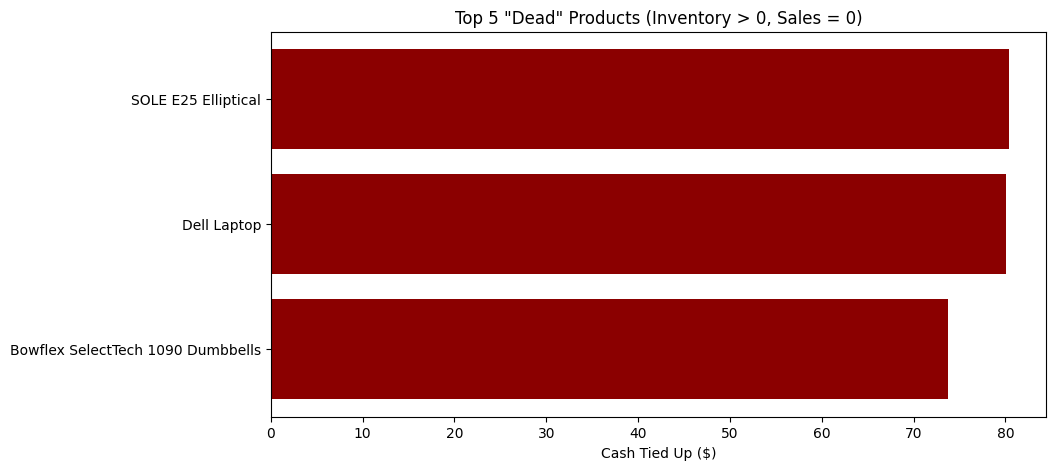

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. SETUP & CLEANING (The "Safe Mode" Load) ---
ord_ship = pd.read_csv('orders_and_shipments.csv')
inv = pd.read_csv('inventory.csv')

# Clean headers
ord_ship.columns = [c.strip() for c in ord_ship.columns]
inv.columns = [c.strip() for c in inv.columns]

# Rename Inventory for matching
inv.rename(columns={'Year Month': 'YearMonth', 'Warehouse Inventory': 'Stock Level', 'Inventory Cost Per Unit': 'Unit Cost'}, inplace=True)

# Force String Keys for Joining
ord_ship['join_key'] = ord_ship['Product Name'].astype(str).str.strip() + "_" + ord_ship['Order YearMonth'].astype(str).str.strip()
inv['join_key'] = inv['Product Name'].astype(str).str.strip() + "_" + inv['YearMonth'].astype(str).str.strip()

# --- 2. CALCULATE DEMAND ---
sales = ord_ship.groupby('join_key')['Order Quantity'].sum().reset_index()
sales.rename(columns={'Order Quantity': 'Total_Sold'}, inplace=True)

# --- 3. IDENTIFY DEAD STOCK ---
# Left Merge: Keep all Inventory, match with Sales
analysis_df = pd.merge(inv, sales, on='join_key', how='left')

# Dead Stock = Items sitting in warehouse (Stock > 0) but Zero Sales (Total_Sold is NaN)
dead_stock = analysis_df[(analysis_df['Total_Sold'].isna()) & (analysis_df['Stock Level'] > 0)]

# Calculate Value
dead_stock['Lost_Cash'] = dead_stock['Stock Level'] * dead_stock['Unit Cost']

# --- 4. THE RESULTS ---
total_lost = dead_stock['Lost_Cash'].sum()
count_items = len(dead_stock)

print("==========================================")
print(f"DEAD STOCK AUDIT COMPLETE")
print(f"Items Hoarded (Zero Sales): {count_items}")
print(f"Total Capital Tied Up: ${total_lost:,.2f}")
print("==========================================")

# --- 5. VISUALIZE THE WORST OFFENDERS ---
# Get Top 5 products by lost cash
top_waste = dead_stock.sort_values('Lost_Cash', ascending=False).head(5)

plt.figure(figsize=(10, 5))
plt.barh(top_waste['Product Name'], top_waste['Lost_Cash'], color='darkred')
plt.xlabel('Cash Tied Up ($)')
plt.title('Top 5 "Dead" Products (Inventory > 0, Sales = 0)')
plt.gca().invert_yaxis() # Flip chart so biggest is at top
plt.show()



---
#**Phase 5: Warehouse Efficiency & Bottleneck Analysis**
Finally, we zoom in on the warehouse floor operations. Using the Fulfillment dataset, we calculate the average Cycle Time—the time taken to pick, pack, and release an order to the carrier.

We visualize product-level bottlenecks to identify specific items that slow down the fulfillment line. This insight allows Operations Managers to re-slot high-friction items or investigate packaging processes to improve overall throughput.

Loading Warehouse Data...
Columns Found: ['Product Name', 'Warehouse Order Fulfillment (days)']
Average Warehouse Processing Time: 5.3 days


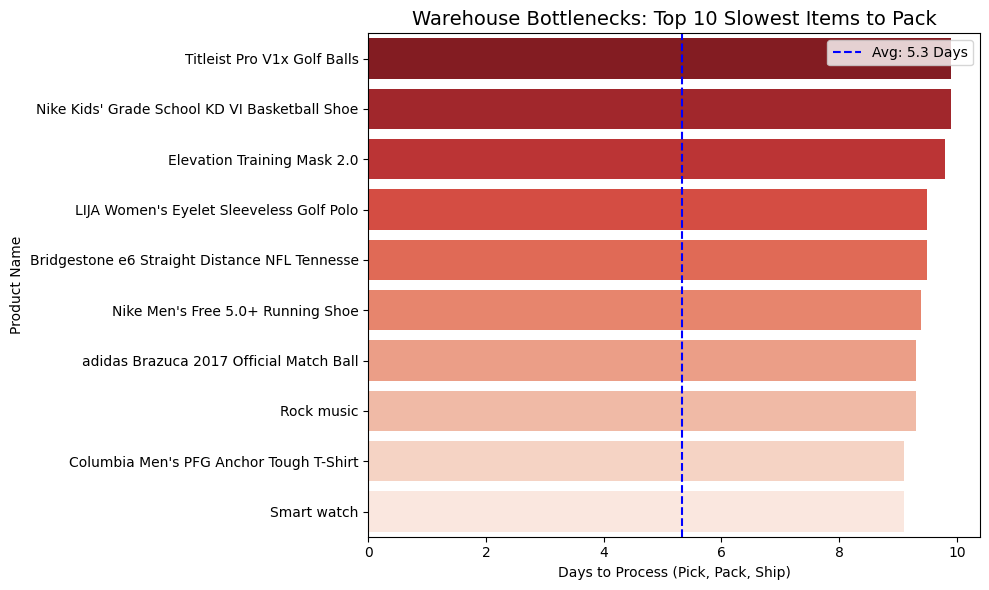

Worst Bottleneck: 'Titleist Pro V1x Golf Balls' takes 9.9 days to leave the warehouse.


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Fulfillment Data
print("Loading Warehouse Data...")
full = pd.read_csv('fulfillment.csv')

# 2. Clean Columns
full.columns = [c.strip() for c in full.columns]
print("Columns Found:", full.columns.tolist())

# 3. Rename for easier coding
full.rename(columns={'Warehouse Order Fulfillment (days)': 'Fulfillment_Days'}, inplace=True)

# 4. Analysis: Top 10 Slowest Products to Pack
# We sort by days descending
slowest_items = full.sort_values('Fulfillment_Days', ascending=False).head(10)

# 5. Calculate Average Baseline
avg_time = full['Fulfillment_Days'].mean()
print(f"Average Warehouse Processing Time: {avg_time:.1f} days")

# 6. Visualize the Bottlenecks
plt.figure(figsize=(10, 6))
sns.barplot(data=slowest_items, y='Product Name', x='Fulfillment_Days', palette='Reds_r')
plt.axvline(avg_time, color='blue', linestyle='--', label=f'Avg: {avg_time:.1f} Days')
plt.title('Warehouse Bottlenecks: Top 10 Slowest Items to Pack', fontsize=14)
plt.xlabel('Days to Process (Pick, Pack, Ship)')
plt.legend()
plt.tight_layout()
plt.show()

# Print the worst offender for the text summary
worst_item = slowest_items.iloc[0]['Product Name']
worst_time = slowest_items.iloc[0]['Fulfillment_Days']
print(f"Worst Bottleneck: '{worst_item}' takes {worst_time} days to leave the warehouse.")